This notebook is to look at new stations - not previously used for training - and to apply the previously trained QC model to the data from a new station

In [3]:
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import dill
import pickle
from scipy import io
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
#My helper functions
from modelNN_functions import assessTrainTestData
from modelNN_functions import plotConfusionMatrix
from modelNN_functions import pandasToMat

In [4]:
#Load the 5 station model
#model = load_model('model_best_NNall_simple.hdf5')
clf = pickle.load(open('model_randomForrest_simple', 'rb'))

In [5]:
#For test data - testing the model on an unseen station
cleaned = pd.read_pickle(Path("pickle_files/8449130_nantucket_raw_ver_merged_wl_Cleaned"))

cleaned.head()

,primary,sigma,backup,verified,prediction,residual,targets
time,,,,,,,
2007-01-01 00:00:00,-0.074,0.009,-0.062,-0.074,-0.081,0.007,1.0
2007-01-01 00:06:00,-0.057,0.004,-0.048,-0.057,-0.062,0.005,1.0
2007-01-01 00:12:00,-0.037,0.003,-0.029,-0.037,-0.043,0.006,1.0
2007-01-01 00:18:00,-0.014,0.006,-0.004,-0.014,-0.024,0.010,1.0
2007-01-01 00:24:00,0.010,0.007,0.018,0.010,-0.005,0.015,1.0


In [6]:
#IMPT if you run this cell twice it will mess up since I am replacing all the NaNs (e.g. the next time through will have none)

primaryTrue = cleaned['primary'].notnull()
cleaned['primaryTrue'] = primaryTrue * 1

sigmaTrue = cleaned['sigma'].notnull()
cleaned['sigmaTrue'] = sigmaTrue * 1

backupTrue = cleaned['backup'].notnull()
cleaned['backupTrue'] = backupTrue * 1

cleaned['primary'].fillna(value=0, inplace = True)
cleaned['sigma'].fillna(value=0, inplace = True)
cleaned['backup'].fillna(value=0, inplace = True)
cleaned['residual'].fillna(value=0, inplace = True)

In [7]:
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] >5, 5)
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] < -5, -5)

cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] >5, 5)
cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] < -5, -5)

cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] >5, 5)
cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] < -5, -5)

cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] > 1, 1)
cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] < 0, 0)

In [8]:
#Now create a previous 6 minute value and following 6 minute value of the primary (and boolean) and the residual (and boolean)
cleaned['primaryPrev6']=cleaned['primary'].shift(periods = 1)
cleaned['primaryTruePrev6']=cleaned['primaryTrue'].shift(periods = 1)
cleaned['residualPrev6']=cleaned['residual'].shift(periods = 1)

cleaned['primaryNext6']=cleaned['primary'].shift(periods = -1)
cleaned['primaryTrueNext6']=cleaned['primaryTrue'].shift(periods = -1)
cleaned['residualNext6']=cleaned['residual'].shift(periods = -1)


#And try grabbing the previous 12 hours of residual and calculating the # of missing data, mean and std as inputs
cleaned['dataCountPrev12h']= (cleaned['primaryTrue'].rolling('12H').sum() / 120)
cleaned['residualMeanPrev12h']= cleaned['residual'][cleaned['primaryTrue'] == 1].rolling('12H').mean() 
cleaned['residualStdPrev12h'] = cleaned['residual'][cleaned['primaryTrue'] == 1].rolling('12H').std() 

#And drop the first and last 12h (120 points)
cleaned.drop(cleaned.head(120).index, inplace=True)
cleaned.drop(cleaned.tail(120).index, inplace=True)

#And drop all the rows where the primaryTrue and verifed = 0 (since we already know these are bad, as they are missing)
cleaned = cleaned[cleaned.primaryTrue == 1]
cleaned = cleaned.dropna()
cleaned

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,primaryPrev6,primaryTruePrev6,residualPrev6,primaryNext6,primaryTrueNext6,residualNext6,dataCountPrev12h,residualMeanPrev12h,residualStdPrev12h
time,,,,,,,,,,,,,,,,,,,
2007-01-01 12:00:00,0.319,0.007,0.327,0.319,0.257,0.062,1.0,1,1,1,0.293,1.0,0.059,0.343,1.0,0.064,1.0,0.021183,0.033145
2007-01-01 12:06:00,0.343,0.005,0.350,0.343,0.279,0.064,1.0,1,1,1,0.319,1.0,0.062,0.369,1.0,0.067,1.0,0.021675,0.033340
2007-01-01 12:12:00,0.369,0.004,0.378,0.369,0.302,0.067,1.0,1,1,1,0.343,1.0,0.064,0.390,1.0,0.066,1.0,0.022183,0.033563
2007-01-01 12:18:00,0.390,0.004,0.398,0.390,0.324,0.066,1.0,1,1,1,0.369,1.0,0.067,0.409,1.0,0.063,1.0,0.022650,0.033781
2007-01-01 12:24:00,0.409,0.004,0.418,0.409,0.346,0.063,1.0,1,1,1,0.390,1.0,0.066,0.428,1.0,0.060,1.0,0.023050,0.033973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 11:36:00,-0.187,0.005,-0.179,-0.187,-0.365,0.178,1.0,1,1,1,-0.166,1.0,0.180,-0.204,1.0,0.178,1.0,0.184733,0.014385
2019-10-31 11:42:00,-0.204,0.004,-0.194,-0.204,-0.382,0.178,1.0,1,1,1,-0.187,1.0,0.178,-0.224,1.0,0.174,1.0,0.184858,0.014259
2019-10-31 11:48:00,-0.224,0.011,-0.216,-0.224,-0.398,0.174,1.0,1,1,1,-0.204,1.0,0.178,-0.238,1.0,0.175,1.0,0.184883,0.014237


In [9]:
NantucketRange = 1.089

GDTrange = NantucketRange

# Get names of scaled features
namesGDTScaled = ['primary','primaryPrev6','primaryNext6','backup','prediction']
namesNotScaled = ['targets','residual','residualPrev6','residualNext6','primaryTrue',
                  'primaryTruePrev6','primaryTrueNext6','sigmaTrue','backupTrue',
                  'dataCountPrev12h','residualMeanPrev12h','residualStdPrev12h']

cleanedScaled=cleaned.copy()
#demean and divide by GDTrange
#for name in namesGDTScaled:
#    cleanedScaled.loc[:,name] = detrend(cleanedScaled.loc[:,name])

cleanedScaled.loc[:,namesGDTScaled] = cleanedScaled.loc[:,namesGDTScaled] / GDTrange

cleanedScaled.head()

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,primaryPrev6,primaryTruePrev6,residualPrev6,primaryNext6,primaryTrueNext6,residualNext6,dataCountPrev12h,residualMeanPrev12h,residualStdPrev12h
time,,,,,,,,,,,,,,,,,,,
2007-01-01 12:00:00,0.292929,0.007,0.300275,0.319,0.235996,0.062,1.0,1,1,1,0.269054,1.0,0.059,0.314968,1.0,0.064,1.0,0.021183,0.033145
2007-01-01 12:06:00,0.314968,0.005,0.321396,0.343,0.256198,0.064,1.0,1,1,1,0.292929,1.0,0.062,0.338843,1.0,0.067,1.0,0.021675,0.033340
2007-01-01 12:12:00,0.338843,0.004,0.347107,0.369,0.277319,0.067,1.0,1,1,1,0.314968,1.0,0.064,0.358127,1.0,0.066,1.0,0.022183,0.033563
2007-01-01 12:18:00,0.358127,0.004,0.365473,0.390,0.297521,0.066,1.0,1,1,1,0.338843,1.0,0.067,0.375574,1.0,0.063,1.0,0.022650,0.033781
2007-01-01 12:24:00,0.375574,0.004,0.383838,0.409,0.317723,0.063,1.0,1,1,1,0.358127,1.0,0.066,0.393021,1.0,0.060,1.0,0.023050,0.033973


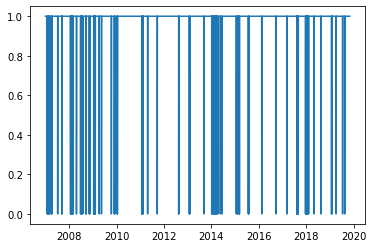

In [18]:
plt.plot(cleanedScaled['targets'])

In [10]:
#These numbers are actually just repeat the total since I have this set up for train and test and now I am 
#repeating the total data twice (will need to modify this)
(totalTrainData, noTrainData) = assessTrainTestData(cleanedScaled,cleanedScaled)

Training Data Points
1110920
Data manually QCed as 0 or bad
12142.0
Fraction of data points which are bad
0.01092967990494365


Testing Data Points
1110920
Data manually QCed as 0 or bad
12142.0
Fraction of data points which are bad
0.01092967990494365


In [12]:
#For complex model
featureNames = ['primary','primaryPrev6','primaryNext6','sigma','backup','prediction','residual',
                              'residualPrev6','residualNext6','primaryTruePrev6','primaryTrueNext6',
                              'sigmaTrue','backupTrue','dataCountPrev12h','residualMeanPrev12h','residualStdPrev12h']

features=cleanedScaled.loc[:, featureNames]


targets=cleanedScaled.loc[:,['targets']]




In [11]:
#For simple model
#Now for the simple model
featureNames = ['primary','sigma','backup','prediction','residual',
                              'sigmaTrue','backupTrue']

features=cleanedScaled.loc[:, featureNames]


targets=cleanedScaled.loc[:,['targets']]

In [25]:
#Generate predictions for the test period
modelPrediction = model.predict(features, batch_size=256)

Normalized confusion matrix
[[0.66 0.34]
 [0.02 0.98]]
total accuracy = 0.9748


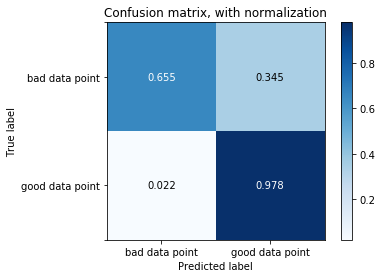

In [26]:
#This is for testing different thresholds with the results of the model

classThreshold =.50
modelPredThresh=1*(modelPrediction >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targets , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()

In [12]:
predictProb = clf.predict_proba(features)[:,1]

Normalized confusion matrix
[[0.69 0.31]
 [0.03 0.97]]
total accuracy = 0.9648


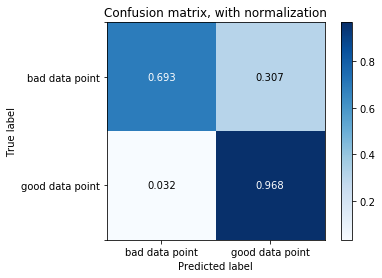

In [14]:
#What is the confusion matrix?

classThreshold =.5
modelPredThresh=1*(predictProb >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targets, modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()
